In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import seaborn as sns


# TODO: reassign functions to their new locations once notebooks and dev-dataloading merge
import gtc_functions
# TODO: clean up notebook

# from h3.dataloading.general_df_utils import (limit_df_spatial_range, 
#     calc_means_df_cols, station_availability)
# from h3.dataloading.noaa_six_hourly_processing import return_most_recent_events_by_name

In [3]:
# TODO: better common path solution. Lisanne's use of Owen's functions? Cambridge-hosted data server?
google_drive_personal_key = '/Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/'

In [4]:
### LOAD IN RELEVANT DFS

# xbd observation points
df_xbd_points_path = google_drive_personal_key + 'datasets/xBD_data/xbd_points_posthurr_reformatted.pkl'
df_xbd_points = pd.read_pickle(df_xbd_points_path)
# noaa 6-hourly
df_noaa_pkl_path = google_drive_personal_key + 'datasets/EFs/weather_data/noaa_hurricanes.pkl'
df_noaa_weather = pd.read_pickle(df_noaa_pkl_path)
# weather stations
df_stations_pkl_path = google_drive_personal_key + 'datasets/EFs/weather_data/weather_stations.pkl'
df_stations = pd.read_pickle(df_stations_pkl_path)
# noaa six-hourly closest to each xbd point
df_noaa_xbd_pkl_path = google_drive_personal_key + 'datasets/EFs/weather_data/xbd_obs_noaa_six_hourly.pkl'
df_noaa_xbd_weather = pd.read_pickle(df_noaa_xbd_pkl_path)
# weather stations infor for each xbd point
df_stations_xbd_pkl_path = google_drive_personal_key + 'datasets/EFs/weather_data/xbd_stations_info.pkl'
df_stations_xbd = pd.read_pickle(df_stations_xbd_pkl_path)


## Visualise stations data availability

In [ ]:
def visualise_station_temporal_availability(
	num_stations: int = -1,
)

	# set number of stations to include (helps visualise data availability): -1 = all
	fig, axs = plt.subplots(1,2,figsize=[12,6]);
	axs = axs.ravel()

	random_slice = np.random.randint()

	for i in range(len(axs)):
		axs[i].set_xlabel('year'), axs[i].set_ylabel('weather stations')
		axs[i].hlines(df_stations.index[:num_stations], 
			df_stations.begin[:num_stations], df_stations.end[:num_stations],
		color='k')

		# formatting
		axs[i].set_facecolor('xkcd:salmon')
		axs[i].set_yticklabels([])

	axs[0].set_title('total weather station observation availability');

	axs[1].set_xlim((max(df_stations.end[:num_stations])-pd.Timedelta(20*365,'d')),max(df_stations.end[:num_stations]));
	axs[1].tick_params(axis='x', labelrotation=45)
	axs[1].set_title('20-year weather station observation availability');

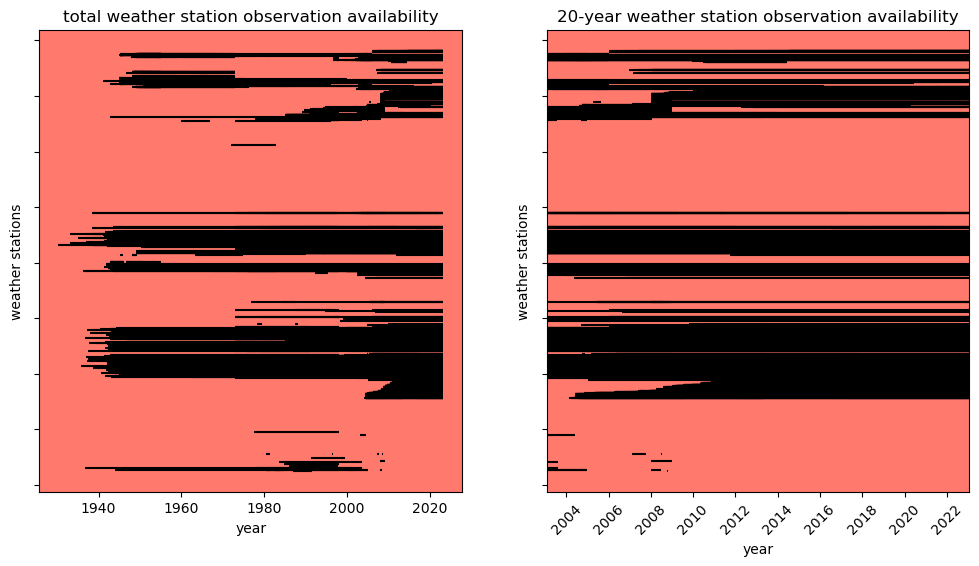

In [5]:
# set number of stations to include (helps visualise data availability): -1 = all
num_stations = -1

fig, axs = plt.subplots(1,2,figsize=[12,6]);
axs = axs.ravel()

for i in range(len(axs)):
    axs[i].set_xlabel('year'), axs[i].set_ylabel('weather stations')
    axs[i].hlines(df_stations.index[:num_stations], 
        df_stations.begin[:num_stations], df_stations.end[:num_stations],
    color='k')

    # formatting
    axs[i].set_facecolor('xkcd:salmon')
    axs[i].set_yticklabels([])

axs[0].set_title('total weather station observation availability');

axs[1].set_xlim((max(df_stations.end[:num_stations])-pd.Timedelta(20*365,'d')),max(df_stations.end[:num_stations]));
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].set_title('20-year weather station observation availability');

### Plot geographical distribution of weather stations

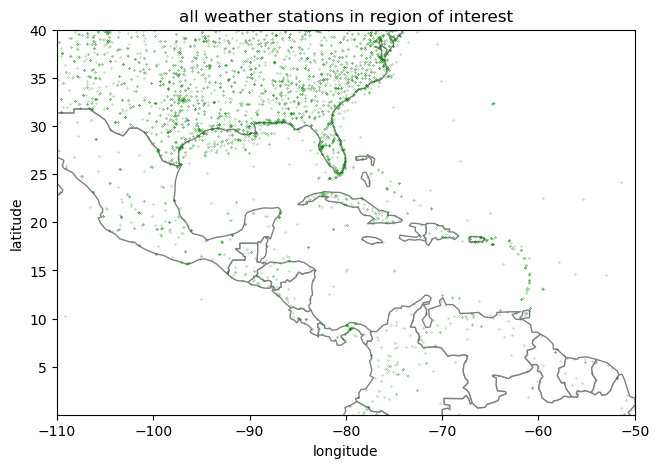

In [6]:
gdf_stations = gpd.GeoDataFrame(df_stations,geometry=gpd.points_from_xy(df_stations.lon,df_stations.lat))

# fetch worldmap and format plot size
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
plt.rcParams['figure.figsize'] = [13, 7]

fig, ax = plt.subplots(figsize=[12,5]);
ax.set_xlabel('longitude'), ax.set_ylabel('latitude')
world.plot(ax=ax,color='white',edgecolor='grey')
gdf_stations.plot(ax=ax,color='green',markersize=0.05,alpha=0.8);

# formatting
ax.set_xlim([min(gdf_stations['lon']),max(gdf_stations['lon'])]);
ax.set_ylim([min(gdf_stations['lat']),max(gdf_stations['lat'])]);
ax.set_title('all weather stations in region of interest');


## Visualise hurricane data

In [7]:
# historic trend of hurricane events (for powerpoint)

# group df by tag and get maximum strength for each 
max_strength_by_tag = df_noaa_weather.groupby(by='tag')['strength'].max()
# create new dataframe containing only max event strength and event_start date for each tag
df_event_max_strengths = pd.DataFrame({
    'date': df_noaa_weather.groupby(by='tag')['date'].min(),
    'strength': max_strength_by_tag})
# exclude rows with maximum strength as 0 (not a hurricane)
df_event_max_strengths = df_event_max_strengths[df_event_max_strengths['strength'] != 0]
df_event_max_strengths.head()

,date,strength
tag,,
##AL011851,1851-06-25 00:00:00,1
AL011852,1852-08-19 00:00:00,3
AL011854,1854-06-25 00:00:00,1
AL011855,1855-08-06 12:00:00,2
AL011856,1856-08-09 00:00:00,4


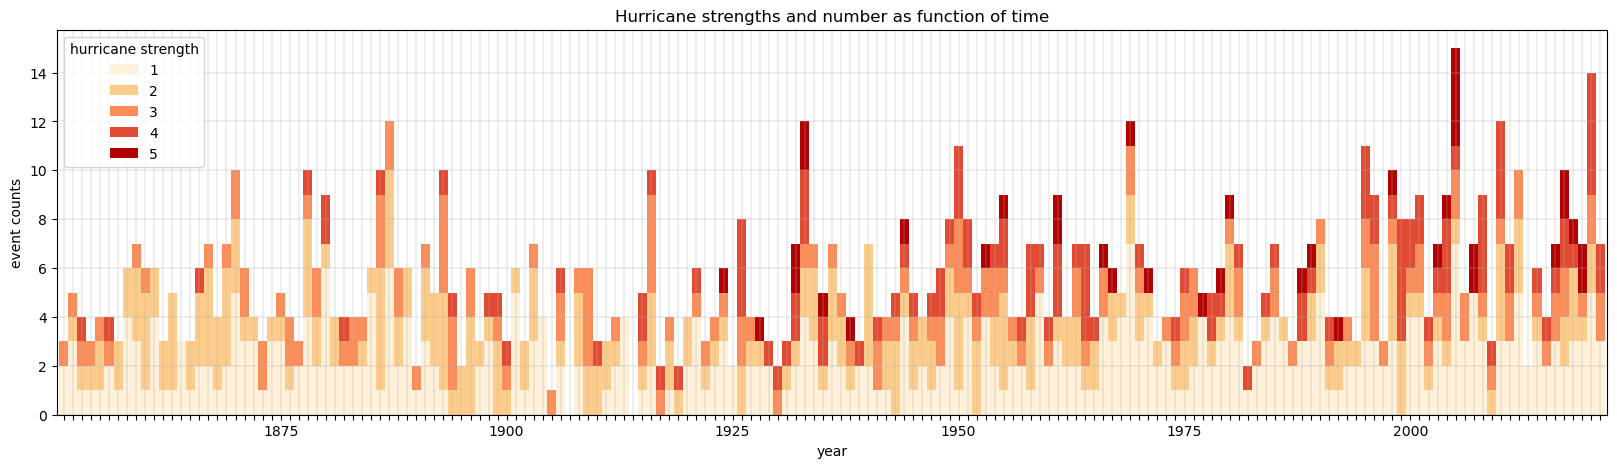

In [8]:
fig,ax = plt.subplots(figsize=[20,5])

# group the data by year and strength, and count the number of events
grouped = df_event_max_strengths.groupby([df_event_max_strengths['date'].dt.year, 'strength']).size().reset_index(name='count')
# pivot the data to create a stacked bar chart
pivot = grouped.pivot(index='date', columns='strength', values='count')

# fill in missing years with rows of nans
years = pd.DataFrame(index=range(pivot.index.min(), pivot.index.max()+1))
full_years = years.merge(pivot, left_index=True, right_index=True, how='outer')
# colour palette
five_colours = ['#fef0d9','#fdcc8a','#fc8d59','#e34a33','#b30000']

full_years.plot(ax=ax, kind='bar', stacked=True, color=five_colours, width=1)

# formatting
ax.set_title('Hurricane strengths and number as function of time')
ax.set_xlabel('year')
ax.set_ylabel('event counts')
# hide all but 25th year – needed to adjust to account for starting at 1851
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if (i+1) % 25 != 0]
ax.legend(title='hurricane strength');
plt.xticks(rotation=0)
ax.grid(which='major',linewidth=0.3)

## Visualise economic and social impact of hurricanes

In [9]:
### Processing damage data. Probably not worth scripting since not used elsewhere.

damage_file = google_drive_personal_key + 'datasets/EFs/weather_data/hurricane_damages/events-US-1980-2022.csv'
# load damage file (cost and fatalities per event)
df_damage_data = pd.read_csv(damage_file,skiprows=[0])
# standardise
df_damage_data_proc = gtc_functions.standardise_dfs(df_damage_data)
# remove any events which aren't hurricanes (also helps with following isolation of names, since event descriptors now
# same length)
df_damage_data_proc = df_damage_data[df_damage_data_proc['name'].str.contains('Hurricane')]
# remove non-name info from 'name' column and make upper case
# TODO: stop setting on copies of df slices
df_damage_data_proc['name'] = df_damage_data_proc['name'].apply(lambda x: x.split()[1].upper())
# format date columns to dt objects
df_damage_data_proc['begin_date'] = pd.to_datetime(df_damage_data_proc['begin_date'], format='%Y%m%d')
df_damage_data_proc['end_date'] = pd.to_datetime(df_damage_data_proc['end_date'], format='%Y%m%d')

df_damage_data_proc.head()

/var/folders/07/lkvjp1kd47578txv8q6wyb9w0000gn/T/ipykernel_5367/662201198.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_damage_data_proc['name'] = df_damage_data_proc['name'].apply(lambda x: x.split()[1].upper())
/var/folders/07/lkvjp1kd47578txv8q6wyb9w0000gn/T/ipykernel_5367/662201198.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_damage_data_proc['begin_date'] = pd.to_datetime(df_damage_data_proc['begin_date'], format='%Y%m%d')
/var/folders/07/lkvjp1kd47578txv8q6wyb9w0000gn/T/ipykernel_

,name,disaster,begin_date,end_date,total_cpi-adjusted_cost_(millions_of_dollars),deaths
0,ALLEN,Tropical Cyclone,1980-08-07,1980-08-11,2106.4,13
1,ALICIA,Tropical Cyclone,1983-08-17,1983-08-20,8910.0,21
2,ELENA,Tropical Cyclone,1985-08-30,1985-09-03,3580.9,4
3,GLORIA,Tropical Cyclone,1985-09-26,1985-09-28,2354.4,11
4,JUAN,Tropical Cyclone,1985-10-27,1985-10-31,4100.9,63


In [10]:
# limit df to only row for each event corresponding to the maximum event strength
df_max_strengths = df_noaa_weather.loc[df_noaa_weather.groupby('tag')['strength'].idxmax()]

# limit noaa weather to include only those hurricanes (by name) which occurred after 1980 for quicker merging
df_lim_eighties_hurricanes = df_max_strengths[(df_max_strengths['date'] >= pd.Timestamp('1980')) & df_max_strengths['strength'] > 0].drop_duplicates(subset='tag',keep='first')
df_lim_eighties_hurricanes.head()

,tag,name,num_entries,date,record_id,sys_status,lat,lon,max_sust_wind,min_p,...,r_se_50,r_nw_50,r_sw_50,r_ne_64,r_se_64,r_nw_64,r_sw_64,r_max_wind,strength,geometry
35207,AL011982,ALBERTO,17,1982-06-03 18:00:00,,HU,24.0,-83.6,75,985.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,POINT (-83.6 24)
39265,AL011995,ALLISON,35,1995-06-04 12:00:00,,HU,24.7,-86.2,65,987.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,POINT (-86.2 24.7)
43735,AL012004,ALEX,25,2004-08-05 00:00:00,,HU,38.5,-66.0,105,957.0,...,80.0,60.0,50.0,30.0,50.0,30.0,20.0,NaN,3,POINT (-66 38.5)
45638,AL012007,ANDREA,31,2007-05-07 06:00:00,,EX,33.3,-72.3,65,998.0,...,50.0,50.0,180.0,180.0,0.0,0.0,0.0,NaN,1,POINT (-72.3 33.3)
49731,AL012016,ALEX,42,2016-01-10 00:00:00,,EX,34.4,-54.2,65,981.0,...,70.0,70.0,100.0,60.0,0.0,50.0,0.0,NaN,1,POINT (-54.2 34.4)


In [11]:
# match events based on name and date N.B. matching noaa df to damages df since noaa larger
# limit noaa df to those with same name as damage data
df_comb_prep = df_lim_eighties_hurricanes[df_lim_eighties_hurricanes.name.apply(lambda x: np.any(np.in1d(x, df_damage_data_proc.name.tolist())))] # no strength nans

# set start time as indexes
df_comb_prep.set_index('date',inplace=True)
df_damage_data_proc_comb = df_damage_data_proc.copy()
df_damage_data_proc_comb.set_index('begin_date',inplace=True)

# set tolerance of event start date
tol = pd.Timedelta(30, 'd')
df_merged = pd.merge_asof(left=df_damage_data_proc_comb,right=df_comb_prep.sort_values('date'),right_index=True,left_index=True,direction='nearest',tolerance=tol)

df_merged.reset_index(inplace=True)
df_merged.head()

,begin_date,name_x,disaster,end_date,total_cpi-adjusted_cost_(millions_of_dollars),deaths,tag,name_y,num_entries,record_id,...,r_se_50,r_nw_50,r_sw_50,r_ne_64,r_se_64,r_nw_64,r_sw_64,r_max_wind,strength,geometry
0,1980-08-07,ALLEN,Tropical Cyclone,1980-08-11,2106.4,13,AL041980,ALLEN,46.0,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,POINT (-66.7 14.8)
1,1983-08-17,ALICIA,Tropical Cyclone,1983-08-20,8910.0,21,AL031983,ALICIA,25.0,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,POINT (-95 28.9)
2,1985-08-30,ELENA,Tropical Cyclone,1985-09-03,3580.9,4,AL051985,ELENA,33.0,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,POINT (-83.9 28.6)
3,1985-09-26,GLORIA,Tropical Cyclone,1985-09-28,2354.4,11,AL051985,ELENA,33.0,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,POINT (-83.9 28.6)
4,1985-10-27,JUAN,Tropical Cyclone,1985-10-31,4100.9,63,AL121985,JUAN,29.0,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,POINT (-91.2 27.8)


In [12]:
# group by event year and event strength and sum the damage amount
grouped = df_merged.groupby([df_merged['begin_date'].dt.year, 'strength']).sum(numeric_only=True).reset_index()
# pivot the table so that event strength is the column and event year is the index
pivoted_deaths = grouped.pivot(index='begin_date', columns='strength', values='deaths')
pivoted_cost = grouped.pivot(index='begin_date', columns='strength', values='total_cpi-adjusted_cost_(millions_of_dollars)')

# fill in missing years with rows of nans
years = pd.DataFrame(index=range(pivoted_cost.index.min(), pivoted_cost.index.max()+1))
full_years_deaths = years.merge(pivoted_deaths, left_index=True, right_index=True, how='outer')
full_years_cost = years.merge(pivoted_cost, left_index=True, right_index=True, how='outer')

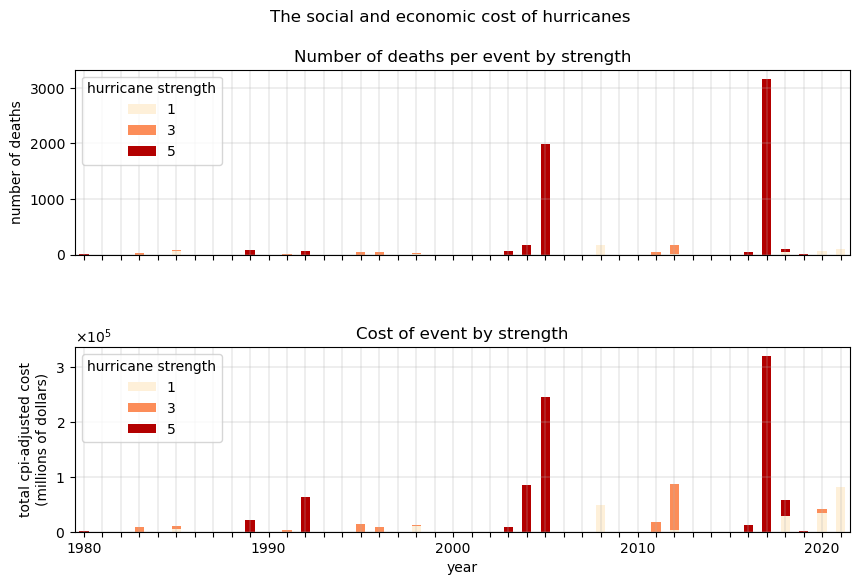

In [13]:
fig, (ax_deaths,ax_cost) = plt.subplots(2, 1, figsize=[10,25], sharex=True)

# plot stacked bar chart
full_years_deaths.plot(ax=ax_deaths, kind='bar', stacked=True, figsize=(10, 6), color=five_colours[::2])
full_years_cost.plot(ax=ax_cost, kind='bar', stacked=True, figsize=(10, 6), color=five_colours[::2])

# format deaths axis
ax_deaths.set_ylabel('number of deaths')
ax_deaths.set_title('Number of deaths per event by strength')

# format cost axis
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3,2))
ax_cost.yaxis.set_major_formatter(formatter)
ax_cost.set_ylabel('total cpi-adjusted cost\n(millions of dollars)')
ax_cost.set_title('Cost of event by strength')

for ax in (ax_deaths,ax_cost):
    ax.legend(title='hurricane strength')
    ax.grid(which='major',linewidth=0.3)

# format both axes
# show only every 10th label
[l.set_visible(False) for (i,l) in enumerate(ax_cost.xaxis.get_ticklabels()) if i % 10 != 0]

ax_cost.set_xlabel('year')
plt.xticks(rotation=0)
plt.suptitle('The social and economic cost of hurricanes');
fig.subplots_adjust(hspace=0.5)

N.B. these look very correlated...  Could be useful to consider whether deaths are a pattern of the country (plot by event) – but probably too small to see in a sample of four events.

In [14]:
df_merged_no_nans = df_merged[df_merged['strength'].notna()]
df_merged_no_nans['strength'] = df_merged_no_nans['strength'].astype('category')

/var/folders/07/lkvjp1kd47578txv8q6wyb9w0000gn/T/ipykernel_5367/1202840300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_no_nans['strength'] = df_merged_no_nans['strength'].astype('category')


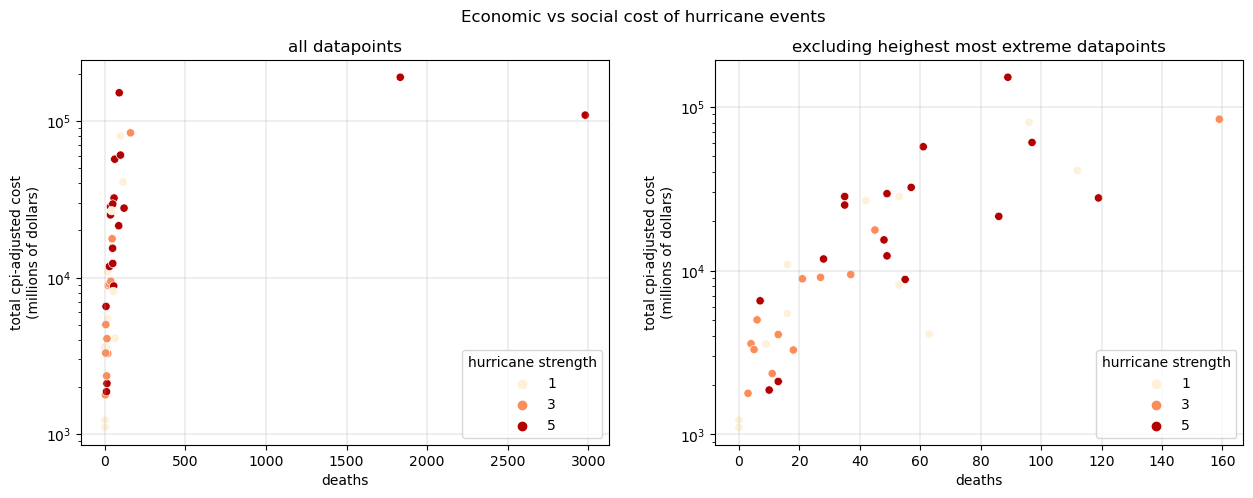

In [15]:
fig, (ax_all, ax_lim) = plt.subplots(1, 2, figsize=[15,5])

# TODO: define once and use this colour map elsewhere – think it's more robust and elegant than a list
strength_colour_map = {1: '#fef0d9', 2: '#fdcc8a', 3: '#fc8d59', 4: '#e34a33', 5: '#b30000'}

sns.scatterplot(ax=ax_all, 
    data=df_merged_no_nans[['deaths', 'total_cpi-adjusted_cost_(millions_of_dollars)','strength']], 
    x='deaths', y='total_cpi-adjusted_cost_(millions_of_dollars)', hue='strength', palette=strength_colour_map)

df_merged_no_nans_lim = df_merged_no_nans[df_merged_no_nans['deaths']<1500]
sns.scatterplot(ax=ax_lim, 
    data=df_merged_no_nans_lim[['deaths', 'total_cpi-adjusted_cost_(millions_of_dollars)','strength']], 
    x='deaths', y='total_cpi-adjusted_cost_(millions_of_dollars)', hue='strength', palette=strength_colour_map)

# formatting
for ax in (ax_all, ax_lim):
    ax.set_yscale('log')
    ax.set_ylabel('total cpi-adjusted cost\n(millions of dollars)')
    ax.grid(which='major',linewidth=0.3)
    ax.legend(title='hurricane strength', loc='lower right')

fig.suptitle('Economic vs social cost of hurricane events');
ax_all.set_title('all datapoints')
ax_lim.set_title('excluding heighest most extreme datapoints');

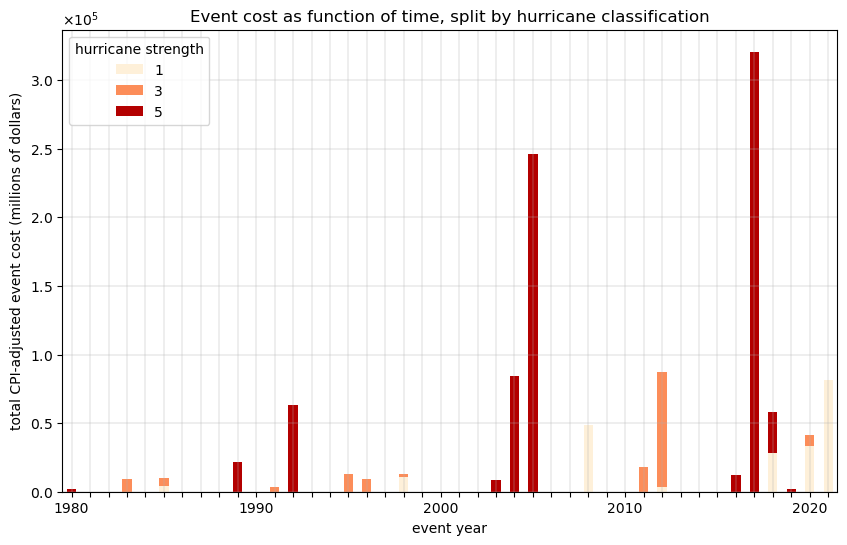

In [16]:
# group by event year and event strength and sum the damage amount
grouped = df_merged.groupby([df_merged['begin_date'].dt.year, 'strength']).sum(numeric_only=True).reset_index()
# pivot the table so that event strength is the column and event year is the index
pivoted = grouped.pivot(index='begin_date', columns='strength', values='total_cpi-adjusted_cost_(millions_of_dollars)')

# fill in missing years with rows of nans
years = pd.DataFrame(index=range(pivoted.index.min(), pivoted.index.max()+1))
full_years = years.merge(pivoted, left_index=True, right_index=True, how='outer')

# plot stacked bar chart
ax_damage = full_years.plot(kind='bar', stacked=True, figsize=(10, 6), color=five_colours[::2])

# formatting
ax_damage.set_xlabel('event year');
ax_damage.set_ylabel('total CPI-adjusted event cost (millions of dollars)');
ax_damage.set_title('Event cost as function of time, split by hurricane classification');
[l.set_visible(False) for (i,l) in enumerate(ax_damage.xaxis.get_ticklabels()) if i % 10 != 0]
ax_damage.grid(which='major',linewidth=0.3)
ax_damage.legend(title='hurricane strength')
plt.xticks(rotation=0)

# set nice y axis labels
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3,2))
ax_damage.yaxis.set_major_formatter(formatter)

In [17]:
pivoted.index[0]

1980

Bizarrely, none of the damage-recorded events are classified as strengths 2 or 4. NaNs in strength column (excluded from plot) result from events matching between NOAA weather and damage quantity data failing. Slightly troubling, given that the data is all from the [same organisation](https://www.ncei.noaa.gov/access/billions/).

## Visualise hurricane tracks for xBD events

In [18]:
# restrict hurricanes df to xbd events
xbd_hurricane_names = ['MICHAEL','MATTHEW','FLORENCE','HARVEY']
df_xbd_hurricanes_noaa = gtc_functions.return_most_recent_events_by_name(df_noaa_weather,xbd_hurricane_names)

# number of 6-hour intervals spanning xbd hurricanes in the Atlantic
num_6s = len(df_xbd_hurricanes_noaa)
print('number of 6-hour intervals spanning xbd hurricanes in the Atlantic: ', num_6s)
# number of 1-hour intervals spanning hurricanes in the Atlantic
# approximate since coarse (may have a couple of hours of weather caused the same
# storm on either end)
num_hourly = num_6s * 6
print('approximate number of 1-hour intervals spanning xbd hurricanes in the Atlantic: ', num_hourly)

number of 6-hour intervals spanning xbd hurricanes in the Atlantic:  241
approximate number of 1-hour intervals spanning xbd hurricanes in the Atlantic:  1446


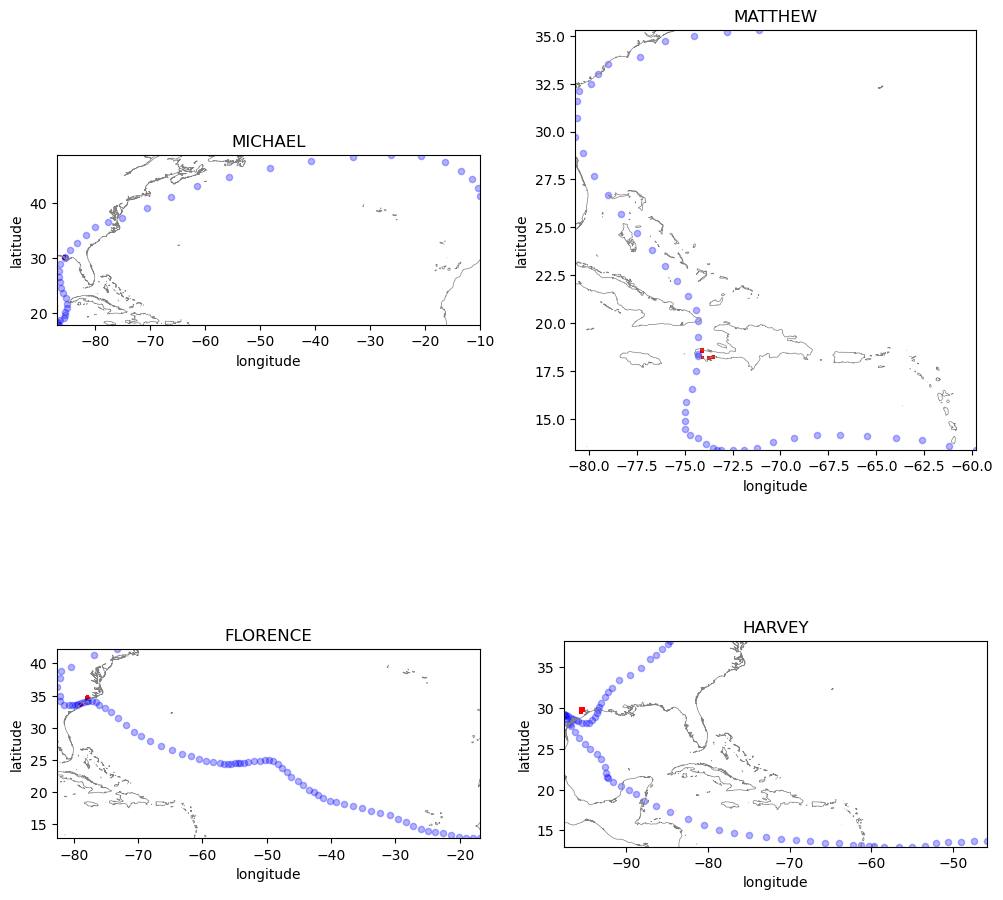

In [19]:
### PLOT HURRICANE TRACKS BY EVENT

# plot xbd locations and relevant NOAA datapoints
fig, axs = plt.subplots(2,2,figsize=[12,12]);
axs = axs.ravel()

# fetch worldmap and format plot size
# TODO: common path – and standardise with what others are using.
# Credit: World Bank https://datacatalog.worldbank.org/search/dataset/0038272/World-Bank-Official-Boundaries
gdf_coastlines = gpd.read_file(google_drive_personal_key + 'datasets/EFs/weather_data/WB_Coastlines.geojson')
plt.rcParams['figure.figsize'] = [13, 7]

for i,name in enumerate(xbd_hurricane_names):
    axs[i].set_title(f'{name}')
    axs[i].set_xlabel('longitude'), axs[i].set_ylabel('latitude')
    gdf_coastlines.plot(ax=axs[i],color='grey',alpha=1,linewidth=0.5)

    gdf_xbd_points = gpd.GeoDataFrame(df_xbd_points[df_xbd_points['disaster_name']==name])
    gdf_xbd_hurricanes_noaa = gpd.GeoDataFrame(df_xbd_hurricanes_noaa[df_xbd_hurricanes_noaa['name']==name])

    gdf_xbd_points.plot(ax=axs[i],color='red',markersize=0.5,alpha=1);
    gdf_xbd_hurricanes_noaa.plot(ax=axs[i],color='blue',markersize=20,alpha=0.3);

    # generate list of observation coordinates
    coords = list(gdf_xbd_points['geometry'])+list(gdf_xbd_hurricanes_noaa['geometry'])
    lats = [pt.y for pt in coords]
    lons = [pt.x for pt in coords]
    # restrict axes limits to zoom in on available data
    axs[i].set_ylim(min(lats),max(lats))
    axs[i].set_xlim(min(lons),max(lons))

/Users/orlandotimmerman/opt/miniconda3/envs/gtc_code/lib/python3.10/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/Users/orlandotimmerman/opt/miniconda3/envs/gtc_code/lib/python3.10/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


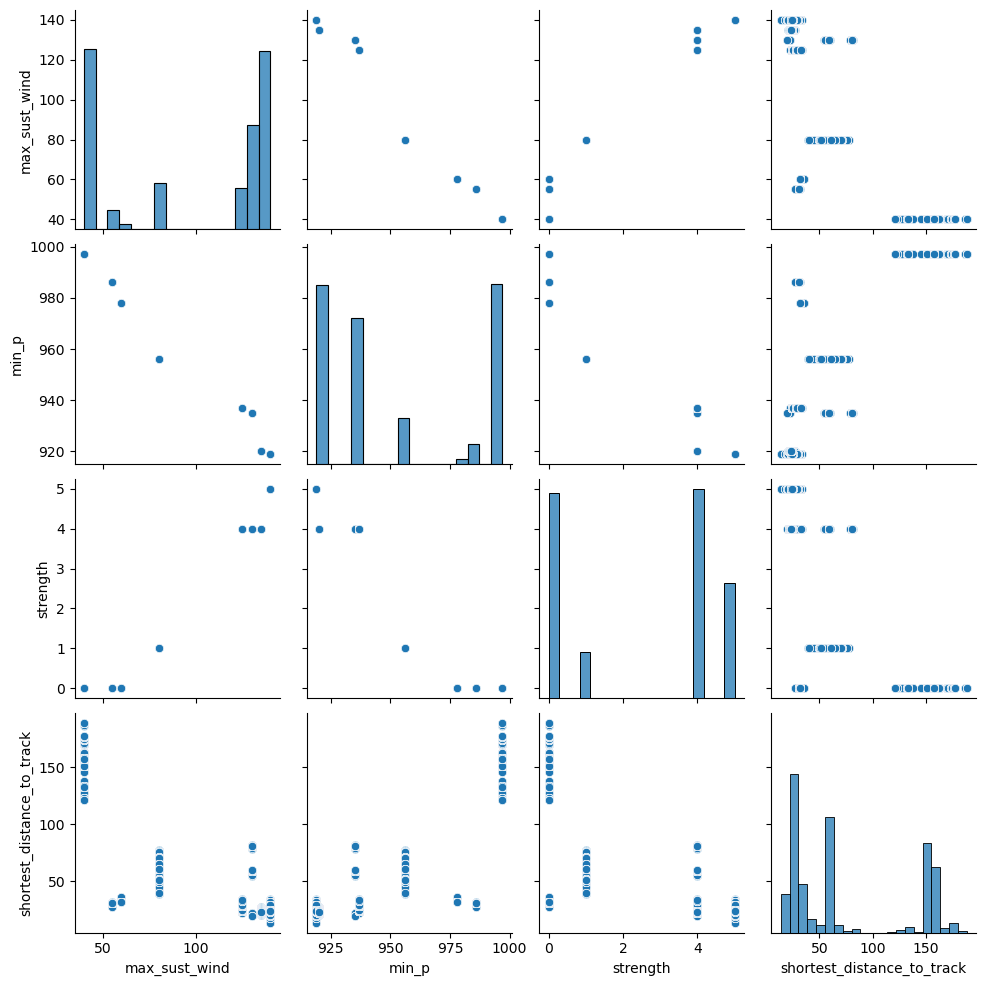

In [20]:
noaa_main_parameters = ['max_sust_wind', 'min_p', 'strength', 'shortest_distance_to_track','name']

sns.pairplot(df_noaa_xbd_weather[noaa_main_parameters]);

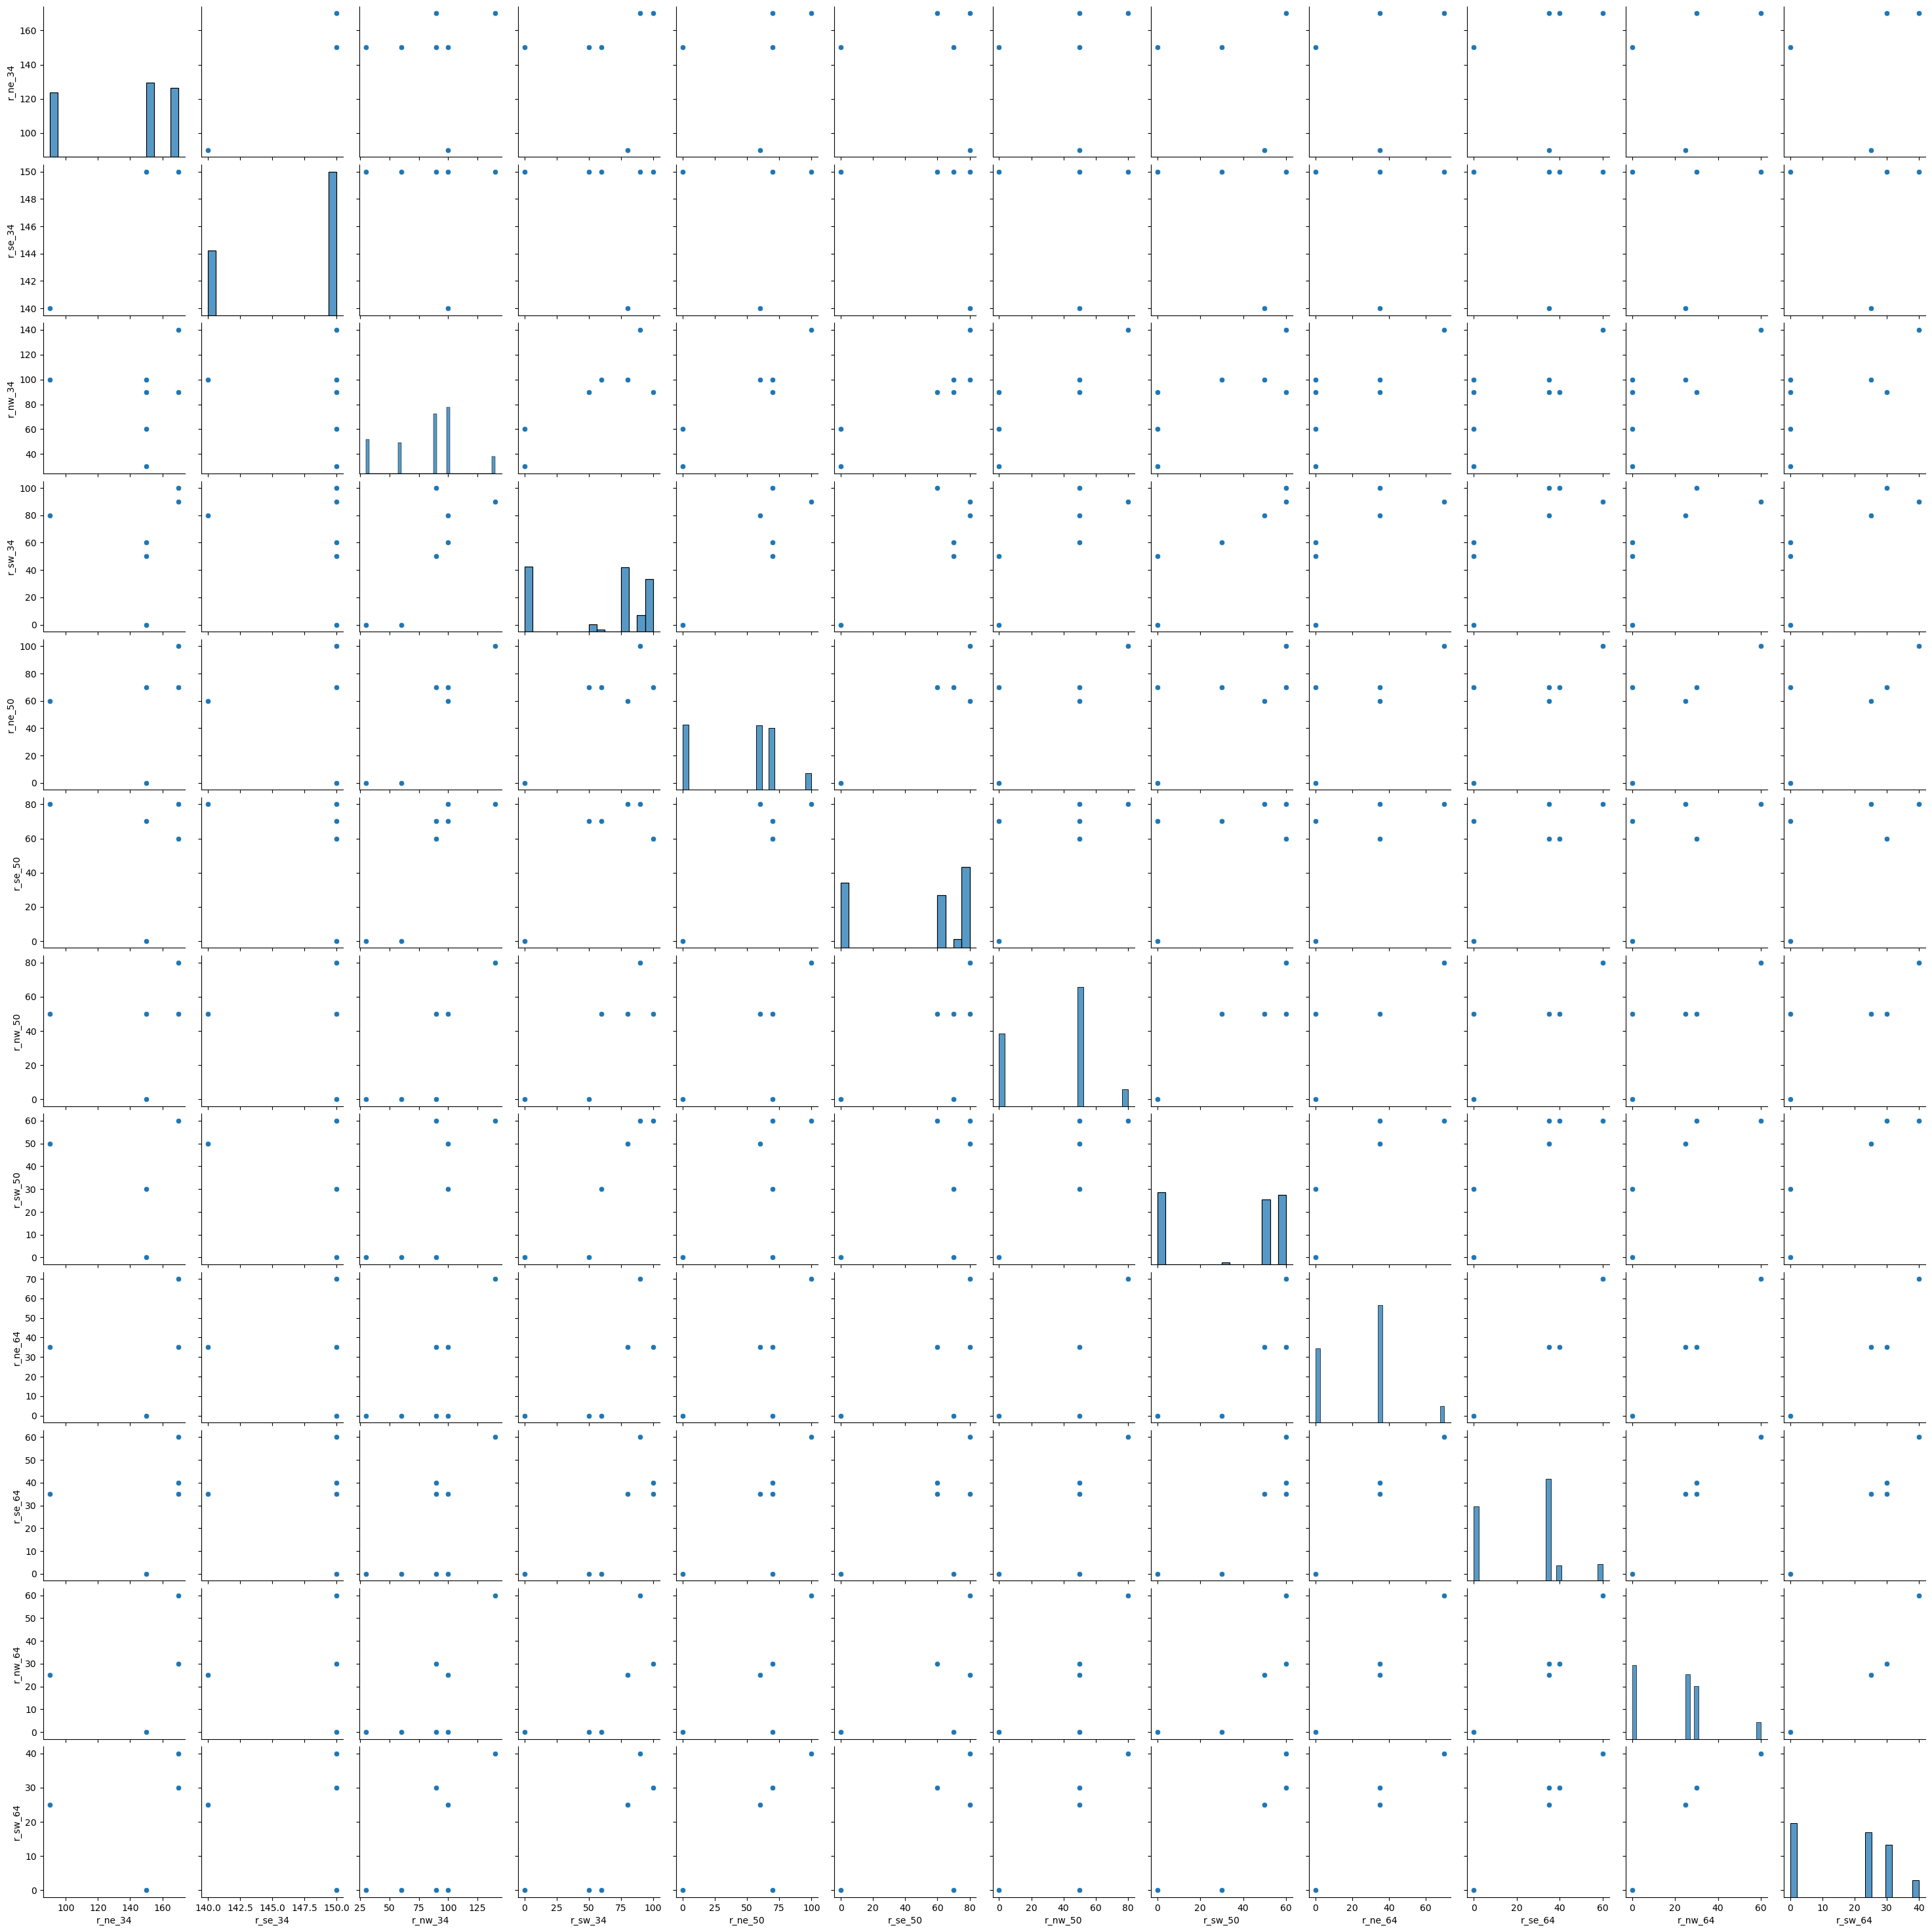

In [21]:
# considered secondary since lower model importance, and more abstract in literature (not mentioned)
noaa_secondary_parameters = ['r_ne_34', 'r_se_34','r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50', 'r_sw_50', 
       'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64']

# WARNING – takes a long time to generate
sns.pairplot(df_noaa_xbd_weather[noaa_secondary_parameters]);


In [22]:
# apart from these dropped columns (all nans), there are no nans in df
df_noaa_xbd_weather.drop(['r_max_wind','stations_lat_lons'],axis=1).isna().sum().value_counts()

0    35
dtype: int64

### Superimpose hurricane tracks and weather stations, investigating local weather station availability

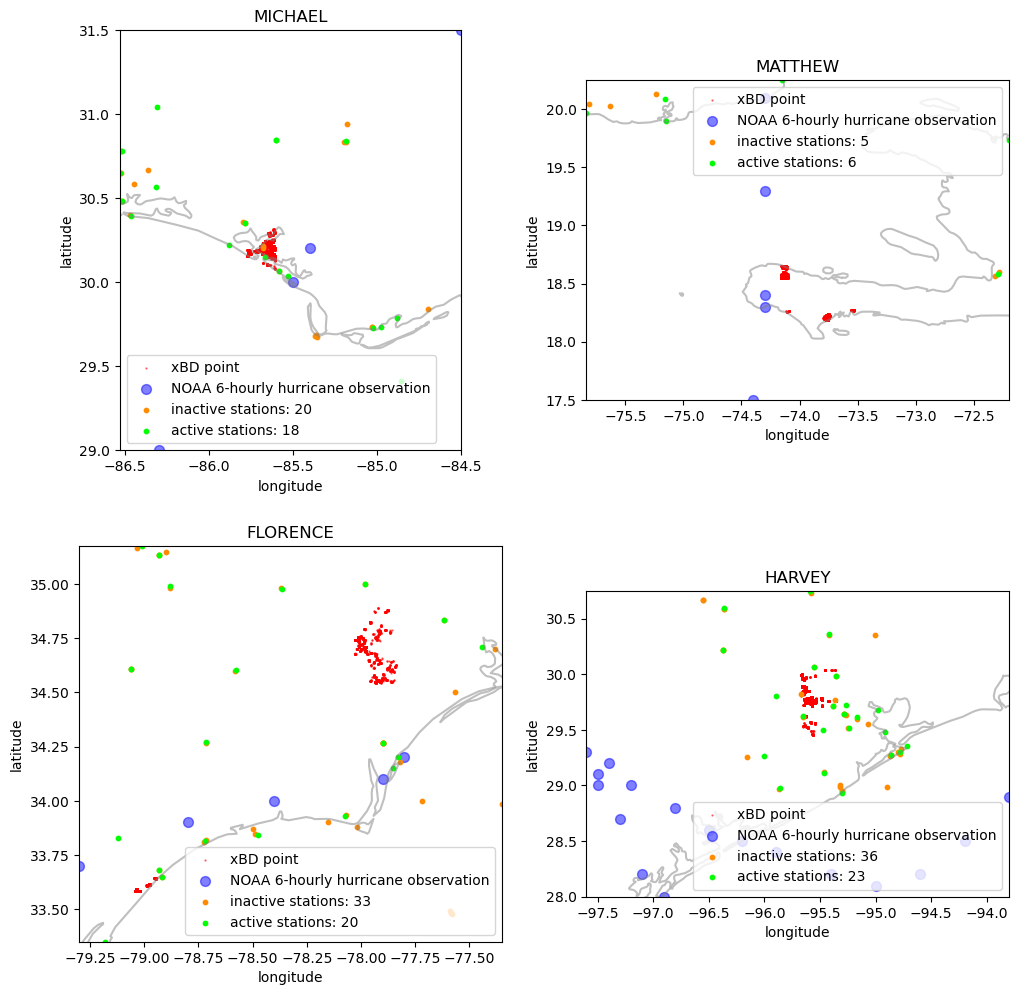

In [23]:
# plot all weather stations against hurricane track and xbd points, zoomed into area of interest
distance_buffer = 5 # units of degress lat-lon

# BY EVENT
# plot xbd locations and relevant NOAA datapoints
fig, axs = plt.subplots(2,2,figsize=[12,12]);
axs = axs.ravel()

# format plot size
plt.rcParams['figure.figsize'] = [13, 7]

for i,name in enumerate(xbd_hurricane_names):
    axs[i].set_title(f'{name}')
    axs[i].set_xlabel('longitude'), axs[i].set_ylabel('latitude')
    gdf_coastlines.plot(ax=axs[i],color='grey',alpha=0.5)

    # xbd observations
    gdf_xbd_points = gpd.GeoDataFrame(df_xbd_points[df_xbd_points['disaster_name']==name])
    gdf_xbd_points.plot(ax=axs[i],color='red',markersize=0.5,alpha=0.5,label='xBD point');

    # noaa 6-hourly weather observations
    gdf_xbd_hurricanes_noaa = gpd.GeoDataFrame(df_xbd_hurricanes_noaa[df_xbd_hurricanes_noaa['name']==name])
    gdf_xbd_hurricanes_noaa.plot(ax=axs[i],color='blue',markersize=50,alpha=0.5,label='NOAA 6-hourly hurricane observation');

    # calculate average lat-lon 
    av_lat,av_lon = gtc_functions.calc_means_df_cols(gdf_xbd_points,['lat','lon'])
    # weather stations
    gdf_event_stations = gtc_functions.limit_df_spatial_range(gdf_stations,[av_lat,av_lon],distance_buffer)

    # inactive weather stations
    gdf_event_stations_inactive = gtc_functions.station_availability(gdf_event_stations,gdf_xbd_hurricanes_noaa,available=False)
    gdf_event_stations_inactive.plot(ax=axs[i],color='darkorange',markersize=10,label=f'inactive stations: {len(gdf_event_stations_inactive)}')

    # active weather stations
    gdf_event_stations_active = gtc_functions.station_availability(gdf_event_stations,gdf_xbd_hurricanes_noaa,available=True)
    gdf_event_stations_active.plot(ax=axs[i],color='lime',markersize=10,alpha=1,label=f'active stations: {len(gdf_event_stations_active)}')

    # ensure that at least 3 hurricane observation points are in the image
    limited_weather_points = gtc_functions.limit_df_spatial_range(gdf_xbd_hurricanes_noaa,[av_lat,av_lon],min_number=3)
    # generate list of observation coordinates, zoomed on xbd points region
    coords = list(gdf_xbd_points['geometry'])+list(gdf_event_stations['geometry'])+list(limited_weather_points['geometry'])
    lats = [pt.y for pt in coords]
    lons = [pt.x for pt in coords]
    # restrict axes limits to zoom in on available data
    axs[i].set_ylim(min(lats),max(lats))
    axs[i].set_xlim(min(lons),max(lons))
    axs[i].legend()


The CMORPH weather data is at a consistent 0.25 degree resolution for all geographical regions. Using this avoids the varying proximity of weather stations to the xBD datapoints seen above, and bypasses the data interpolation steps necessary to get the weather station data into a workable format. 

The poor data seen in the weather stations data raises questions as to the validity of GaLeNet's use of the same data via the OpenWeatherMap API...

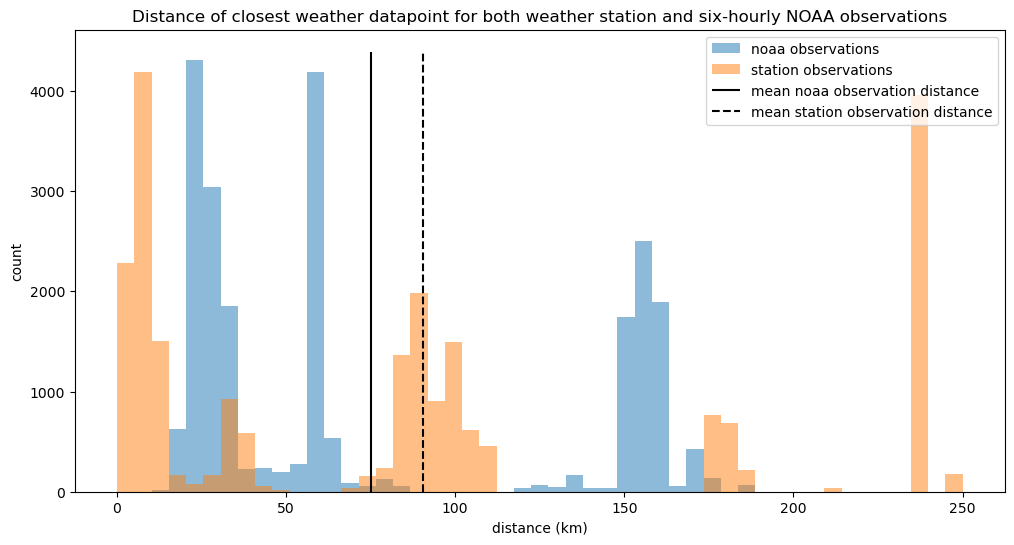

In [24]:
# compare distances between NOAA observations and weather station observations
# relative to xbd points

# calculate average distances
av_noaa_xbd_distance = df_noaa_xbd_weather['shortest_distance_to_track'].mean()
av_station_distance = df_stations_xbd['distance_to_closest'].mean()

fig,ax_hist = plt.subplots(figsize=[12,6])

# plot histogram
bins = np.linspace(0,250,50)
n_noaa,_,_ = ax_hist.hist(df_noaa_xbd_weather['shortest_distance_to_track'],bins,alpha=0.5,label='noaa observations');
n_stations,_,_ = ax_hist.hist(df_stations_xbd['distance_to_closest'],bins,alpha=0.5,label='station observations');

# plot means
ax_hist.vlines(av_noaa_xbd_distance,ymin=0,ymax=np.max(n_noaa+n_stations),color='k',label='mean noaa observation distance')
ax_hist.vlines(av_station_distance,ymin=0,ymax=np.max(n_noaa+n_stations),color='k',ls='--',label='mean station observation distance')

# formatting
ax_hist.set_title('Distance of closest weather datapoint for both weather station and six-hourly NOAA observations')
ax_hist.set_xlabel('distance (km)'), ax_hist.set_ylabel('count')
ax_hist.legend(loc='upper right');


The histogram above shows that the weather stations are on average further from the xBD observations than the NOAA observations, even though there is a relatively large number of very close stations. This may well be because for some events (likely Hurricane Matthew) had very few nearby stations. This is telling of the inequality of infrastructure between the US and the Caribbean islands. Yet another reason to use geography-agnostic CMORPH data.

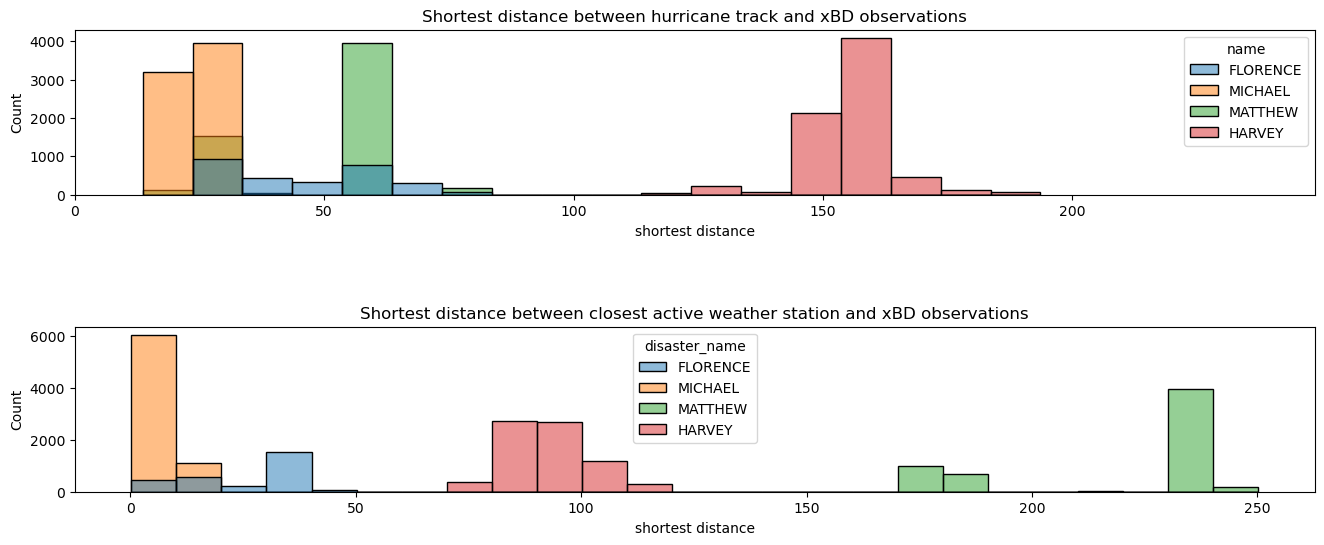

In [25]:
fig,(ax_noaa,ax_station) = plt.subplots(2, 1, figsize=[16,6])

# TODO: put into script more efficiently, add on average vlines
sns.histplot(ax=ax_noaa,data=df_noaa_xbd_weather,x='shortest_distance_to_track',hue='name',binwidth=10);
sns.histplot(ax=ax_station,data=df_stations_xbd,x='distance_to_closest',hue='disaster_name',binwidth=10);

ax_noaa.set_title('Shortest distance between hurricane track and xBD observations')
ax_noaa.set_xlabel('shortest distance')
ax_station.set_title('Shortest distance between closest active weather station and xBD observations')
ax_station.set_xlabel('shortest distance')

xs = df_noaa_xbd_weather['shortest_distance_to_track'].tolist() + df_stations_xbd['distance_to_closest'].tolist()
ax_noaa.set_xlim(xmin=0,xmax=max(xs))

fig.subplots_adjust(hspace=0.8)

## Hurricane Track Animation

In [26]:
# TODO: animate HURDAT best track data (thanks Owen)

# for each event
# plot each observation as a function of time, showing movement of hurricane centre (row) over the worldmap
# could add in any extra detail, e.g. changing size/colour of point to reflect changing weather conditions. Perhaps
# could increase in area in proportion to the max_sust_wind, and change colour to indicate when strength categorisation 
# changes. 
# Would recommend using the strength colours used above ('five_colours' variable). xBD datapoints also available
# for plotting on the map: it would be cool to see how the hurricane event passes above the points.

df_xbd_hurricanes_noaa

,tag,name,num_entries,date,record_id,sys_status,lat,lon,max_sust_wind,min_p,...,r_se_50,r_nw_50,r_sw_50,r_ne_64,r_se_64,r_nw_64,r_sw_64,r_max_wind,strength,geometry
51171,AL062018,FLORENCE,79,2018-09-18 12:00:00,,EX,42.2,-73.3,25,1006.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,POINT (-73.3 42.2)
51170,AL062018,FLORENCE,79,2018-09-18 06:00:00,,EX,41.3,-76.8,25,1007.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,POINT (-76.8 41.3)
51169,AL062018,FLORENCE,79,2018-09-18 00:00:00,,EX,39.5,-80.5,25,1008.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,POINT (-80.5 39.5)
51168,AL062018,FLORENCE,79,2018-09-17 18:00:00,,EX,38.8,-82.0,25,1008.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,POINT (-82 38.8)
51167,AL062018,FLORENCE,79,2018-09-17 12:00:00,,EX,37.8,-82.2,25,1008.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,POINT (-82.2 37.8)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51435,AL142018,MICHAEL,38,2018-10-07 18:00:00,,TS,19.1,-85.7,45,999.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,POINT (-85.7 19.1)
51434,AL142018,MICHAEL,38,2018-10-07 12:00:00,,TS,18.8,-86.4,35,1003.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,POINT (-86.4 18.8)
51433,AL142018,MICHAEL,38,2018-10-07 06:00:00,,TD,18.4,-86.8,30,1004.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,POINT (-86.8 18.4)
51432,AL142018,MICHAEL,38,2018-10-07 00:00:00,,LO,18.1,-86.9,25,1004.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,POINT (-86.9 18.1)


In [27]:


# fig = plt.figure() 
# ax = plt.axes() 
# line, = ax.plot([], [], lw=2) 

# # initialization function 
# def init(): 
#     # creating an empty plot/frame 
#     line.set_data([], []) 
#     return line, 

# # lists to store x and y axis points 
# xdata, ydata = [], [] 

# # animation function 
# def animate(i): 
#     for event, subdf in df_xbd_hurricanes_noaa.groupby('tag'):
#         xdata.append(subdf['lat'])
#         ydata.append(subdf['lon'])
#         line.set_data(xdata, ydata) 
#         return line, 

# # setting a title for the plot 
# plt.title('') 
# # hiding the axis details 
# #plt.axis('off') 

# # call the animator  
# anim = animation.FuncAnimation(fig, animate, init_func=init, interval=100,blit=True) 


In [28]:
# import plotly.graph_objs as go


# fig = go.Figure(
#     go.Scattermapbox(
#         lat=df_xbd_hurricanes_noaa['lat'],
#         lon=df_xbd_hurricanes_noaa['lon'],
#         mode='markers',
#         marker=dict(
#             size=10,
#             color=df_xbd_hurricanes_noaa['date'],
#             colorscale='Viridis',
#             cmin=min(df_xbd_hurricanes_noaa['date']),
#             cmax=max(df_xbd_hurricanes_noaa['date']),
#             colorbar=dict(
#                 title='Date',
#                 x=0.93,
#                 y=0.5,
#                 len=0.6
#             )
#         )
#     )
# )

# fig.update_layout(
#     mapbox=dict(
#         accesstoken='your_mapbox_token_here',
#         bearing=0,
#         center=dict(
#             lat=data['latitude'].mean(),
#             lon=data['longitude'].mean()
#         ),
#         pitch=0,
#         zoom=5
#     ),
#     width=800,
#     height=600,
#     margin=dict(
#         l=10,
#         r=10,
#         b=10,
#         t=10
#     )
# )




In [29]:
# import plotly.offline as pyo
# pyo.iplot(fig)


In [30]:
import matplotlib.animation as animation 

def animate(i):
    plt.clf()
    plt.scatter(df_xbd_hurricanes_noaa['lon'][i], df_xbd_hurricanes_noaa['lat'][i], s=10, color='red')
    plt.xlim(df_xbd_hurricanes_noaa['lon'].min(), df_xbd_hurricanes_noaa['lon'].max())
    plt.ylim(df_xbd_hurricanes_noaa['lat'].min(), df_xbd_hurricanes_noaa['lat'].max())
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Latitude and Longitude over Time')


In [31]:
ani = animation.FuncAnimation(plt.gcf(), animate, frames=len(df_xbd_hurricanes_noaa), interval=500, repeat=False)
plt.show()


<Figure size 1300x700 with 0 Axes>